In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [6]:
df1 = pd.read_csv('/home/vsarg/Downloads/Ankur Formal Project/Datasets/5a_40A.csv')
df2 = pd.read_csv('/home/vsarg/Downloads/Ankur Formal Project/Datasets/5a_45A.csv')
df3 = pd.read_csv('/home/vsarg/Downloads/Ankur Formal Project/Datasets/5a_50A.csv')
df4 = pd.read_csv('/home/vsarg/Downloads/Ankur Formal Project/Datasets/5a_60A.csv')
df5 = pd.read_csv('/home/vsarg/Downloads/Ankur Formal Project/Datasets/5b_40A.csv', header = None)
df6 = pd.read_csv('/home/vsarg/Downloads/Ankur Formal Project/Datasets/5b_45A.csv', header = None)
df7 = pd.read_csv('/home/vsarg/Downloads/Ankur Formal Project/Datasets/5b_50A.csv', header = None)
df8 = pd.read_csv('/home/vsarg/Downloads/Ankur Formal Project/Datasets/5b_60A.csv', header = None)

df5.columns = df1.columns
df6.columns = df1.columns
df7.columns = df1.columns
df8.columns = df1.columns

In [241]:
df8

,Hours,Temperature
0,-0.007279,15.630807
1,0.007335,15.689042
2,0.007335,15.630807
3,0.014642,15.630807
4,0.014642,15.572572
...,...,...
6713,2.944779,47.019560
6714,2.944779,46.961325
6715,2.944779,46.903090
6716,2.952086,47.019560


In [242]:
X = df8['Hours']
y = df8['Temperature']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.3, shuffle=False)

In [243]:
y_train.to_numpy().reshape(-1, 1)

array([[15.63080685],
       [15.68904201],
       [15.63080685],
       ...,
       [45.73838631],
       [45.68015114],
       [45.62191598]])

In [244]:
scaler = MinMaxScaler()
scaler.fit(y_train.to_numpy().reshape(-1, 1))
scaled_train = scaler.transform(y_train.to_numpy().reshape(-1, 1))
scaled_test = scaler.transform(y_test.to_numpy().reshape(-1, 1))
scaled_y = scaler.transform(y.to_numpy().reshape(-1, 1))

scaled_train[:10]

array([[0.02578269],
       [0.02762431],
       [0.02578269],
       [0.02578269],
       [0.02394107],
       [0.01289134],
       [0.01104972],
       [0.02578269],
       [0.02394107],
       [0.02209945]])

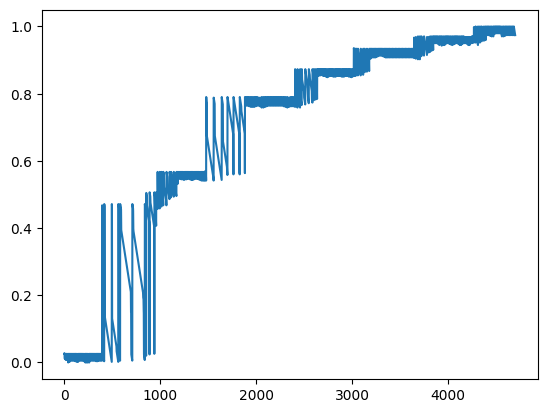

In [245]:
plt.plot(scaled_train)

In [246]:
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [247]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [248]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 100)               40800     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [249]:
model.fit(generator,epochs=50)

Epoch 1/50
4697/4697 [==============================] - 9s 2ms/step - loss: 0.0041
Epoch 2/50
4697/4697 [==============================] - 8s 2ms/step - loss: 0.0013
Epoch 3/50
4697/4697 [==============================] - 8s 2ms/step - loss: 0.0011
Epoch 4/50
4697/4697 [==============================] - 8s 2ms/step - loss: 0.0011
Epoch 5/50
4697/4697 [==============================] - 8s 2ms/step - loss: 0.0010
Epoch 6/50
4697/4697 [==============================] - 9s 2ms/step - loss: 9.9084e-04
Epoch 7/50
4697/4697 [==============================] - 9s 2ms/step - loss: 9.9659e-04
Epoch 8/50
4697/4697 [==============================] - 9s 2ms/step - loss: 9.6303e-04
Epoch 9/50
4697/4697 [==============================] - 9s 2ms/step - loss: 9.6821e-04
Epoch 10/50
4697/4697 [==============================] - 9s 2ms/step - loss: 9.4941e-04
Epoch 11/50
4697/4697 [==============================] - 9s 2ms/step - loss: 9.3725e-04
Epoch 12/50
4697/4697 [==============================] - 9s 2

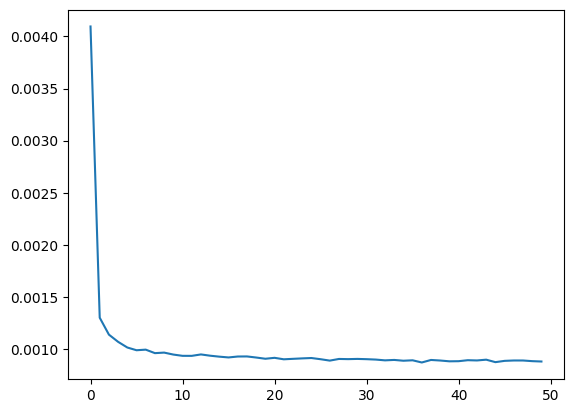

In [250]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [251]:
test_predictions = []

first_eval_batch = scaled_train[0:n_input]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in tqdm(range(n_input, len(scaled_y))):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch, verbose=0)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[scaled_y[i]]],axis=1)

  0%|          | 0/6713 [00:00<?, ?it/s]

In [252]:
len(test_predictions)

6713

In [253]:
y_test

4702    46.437208
4703    46.378973
4704    46.320738
4705    46.262503
4706    46.204268
          ...    
6713    47.019560
6714    46.961325
6715    46.903090
6716    47.019560
6717    46.961325
Name: Temperature, Length: 2016, dtype: float64

In [254]:
true_predictions = scaler.inverse_transform(test_predictions)

df = pd.DataFrame({'Hours': X[n_input:], 'Temperature': y[n_input:], 'Prediction': true_predictions.flatten()}).set_index('Hours')
df

,Temperature,Prediction
Hours,,
0.014642,15.223161,15.434782
0.014642,15.164926,15.276239
0.021949,15.630807,15.266090
0.021949,15.572572,15.493595
0.021949,15.514337,15.418784
...,...,...
2.944779,47.019560,46.695961
2.944779,46.961325,46.900880
2.944779,46.903090,46.829051


In [255]:
true_predictions

array([[15.43478203],
       [15.27623903],
       [15.26609   ],
       ...,
       [46.82905061],
       [46.76878602],
       [46.88600926]])

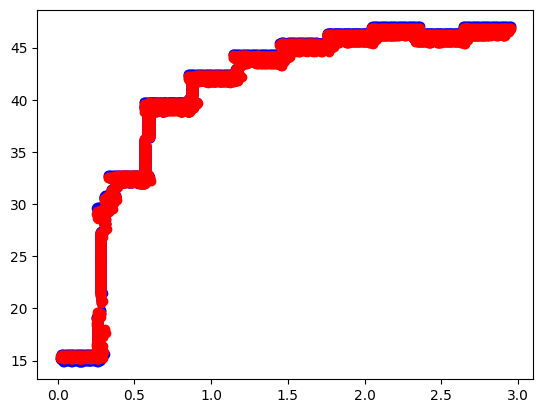

In [256]:
plt.plot(df['Temperature'], 'bo')
plt.plot(df['Prediction'], 'ro')

In [257]:
N = len(y)
mse_error = (1/ N) * sum((y[n_input:] - true_predictions.flatten()) ** 2)
rmse_error = np.sqrt(mse_error) 
mae_error = (1/ N) * sum(abs(y[n_input:] - true_predictions.flatten()))
print(mse_error)

0.6027186750031768


In [258]:
print(rmse_error)

0.7763495829864127


In [259]:
print(mae_error)

0.17560543306084248


In [260]:
u = ((y[n_input:] - true_predictions.flatten())** 2).sum()
v = ((y[n_input:] - y[n_input:].mean())** 2).sum()
r2_error = 1-(u/v)
print(r2_error)

0.9930983150063726


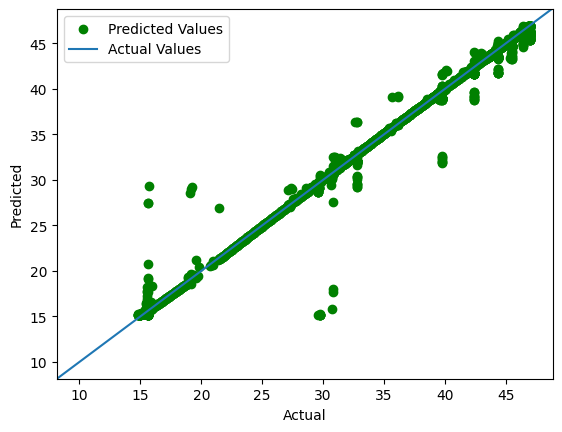

In [261]:
plt.ylabel("Predicted")
plt.xlabel("Actual")

plt.scatter(y[n_input:],true_predictions.flatten(),color='green', label='Predicted Values')
plt.axline([10, 10], [35, 35],label='Actual Values')
plt.legend(loc ="upper left")
plt.show()

In [262]:
subset = np.random.choice(len(X)-n_input, 150)

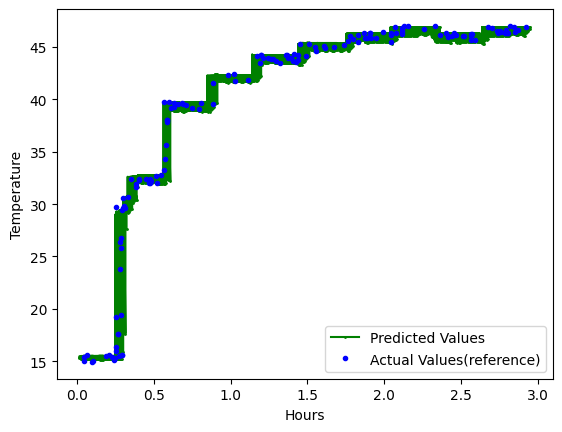

In [263]:
plt.ylabel("Temperature")
plt.xlabel("Hours")

plt.plot(X[n_input:], true_predictions.flatten(), marker='o', color='g',markersize=1, linestyle="-", label='Predicted Values')
plt.plot(X[subset + n_input], y[subset + n_input], marker='o', color='b',linestyle="None",markersize=3, label='Actual Values(reference)')
plt.legend(loc ="lower right")
plt.show()